In [1]:
import argparse
import time
from pathlib import Path

import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn

from numpy import random
import os
import matplotlib.pyplot as plt

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)

# SET UP VIETOCR 
config = Cfg.load_config_from_name('vgg_transformer')
config = Cfg.load_config_from_file('VietOCR/config.yml')
config['weights'] = 'VietOCR/weights/transformerocr.pth'
config['cnn']['pretrained']=False
config['device'] = 'cpu'
config['predictor']['beamsearch']=False
detector = Predictor(config)

# SET UP CRAFT TEXT DETECTOR

c:\Users\nhatn\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nhatn\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\nhatn\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:
def craft_text_func(list_img:list,craft_net,refine_net):
    opencvImage = cv2.cvtColor(np.array(list_img), cv2.COLOR_RGB2BGR)
    prediction_result = get_prediction(
    image= opencvImage,
    craft_net=craft_net,
    refine_net=refine_net,
    text_threshold=0.77,
    link_threshold=0.7,
    low_text= 0.22,
    cuda=False,)
    empty_cuda_cache()
    s=""
    img_demo = []
    toa_do = []
    for i in prediction_result["boxes"]:
        a=i.T[0]
        b=i.T[1]
        top_left_x = min(a)
        top_left_y = min(b)
        bot_right_x = max(a)
        bot_right_y = max(b)
        toa_do.append(top_left_x+top_left_y)
        img_demo.append(list_img.crop((  top_left_x,top_left_y,bot_right_x+1,bot_right_y+1)))
    list_toa_do = sorted(toa_do)
    toa_do =[ str(i) for i in toa_do]
    for i in list_toa_do:
      s = s + " " + detector.predict(img_demo[int(toa_do.index(str(i)))])
    return s
CLASSES=['Phai', 'Phai-Dia diem', 'Phai-Khoang cach', 'Thang', 'Thang-Dia diem', 'Thang-Khoang cach', 'Trai', 'Trai-Dia diem', 'Trai-Khoang cach', 'Ra1', 'Ra1-Dia diem', 'Ra1-Khoang cach', 'Ra2', 'Ra2-Dia diem', 'Ra2-Khoang cach', 'Ra3', 'Ra3-Dia diem', 'Ra3-Khoang cach', 'Chech Phai', 'Chech Phai-Dia diem', 'Chech Phai-Khoang cach', 'Chech Trai', 'Chech Trai-Dia diem', 'Chech Trai-Khoang cach']


In [3]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [4]:
# Hàm lấy index của hướng từ nhãn.
def Index_Direction_func(a: float):
    return Direction.index(CLASSES[int(a)].split('-')[0])


# Hàm tạo ra list các hướng.
def List_Direction_func(a: list):
  b=[]
  for i in a:
    b.append(Index_Direction_func(i))
  return list(set(b))

# Tao ra list nhiều chiều theo từng hướng chỉ dẫn.
def Crear_drection_list(list_index: list):
  b = List_Direction_func(list_index)
  val = [[0] for i in range(len(b))]
  for i in range(len(val)):
    val[i][0] = Huong[int(b[i])]
    for y in list_index:
      if Index_Direction_func(y) == int(b[i]):
        val[i].append(y)
  for i in val:
    i[1:] = sorted(i[1:])
  return val

def Text_detect(list_predict:list,list_index,list_img,craft_net,refine_net):
  Text = []
  for i in list_predict:
    s= ''
    if len(i) == 4:
      if i[2] != i[3]:
        s = i[0] + " " + craft_text_func(list_img[list_index.index(i[3])],craft_net,refine_net) + " tới" + craft_text_func(list_img[list_index.index(i[2])],craft_net,refine_net)       
      if i[2] == i[3]:
        s = i[0] + " tới" + craft_text_func(list_img[list_index.index(i[2])],craft_net,refine_net) + " hoặc " + craft_text_func(list_img[list_index.index(i[3])+1],craft_net,refine_net)   
    Text.append(s) 
    print(s)   
    if len(i) == 3:
      s = i[0] + " tới" + craft_text_func(list_img[list_index.index(i[2])],craft_net,refine_net)
      print(s)
      Text.append(s)

  return Text 
Index_Direction = []
for i in range(0,24,3):
        Index_Direction.append(i)

Direction = []
for i in Index_Direction:
        Direction.append(CLASSES[i])
Huong = ['Rẻ phải','Đi thẳng','Rẻ trái','Đi theo vòng xoay: Hướng ra thứ nhất','Đi theo vòng xoay: Hướng ra thứ hai','Đi theo vòng xoay: Hướng ra thứ ba','Đi chếch phải','Đi chếch trái']


In [66]:
a[0]

'RẺ PHẢI  58 KM TỚI QL 1AendlĐI THẲNG  35 KM TỚI T.X AN NHƠNendl'

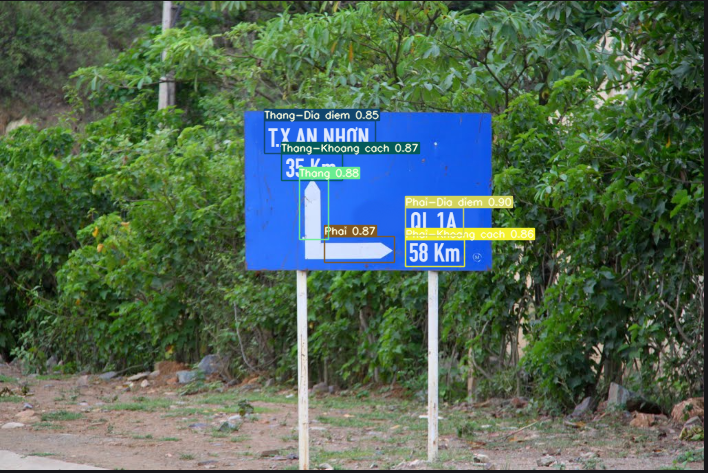

In [67]:

image = Image.fromarray(a[1])
image

In [89]:
import streamlit as st

In [1]:
s = 'sssssssssssssss' + "\n"  +"SSSSSSSS"
s

'sssssssssssssss\nSSSSSSSS'

In [109]:
print(s)

sssssssssssssss
SSSSSSSS


In [2]:
a[0]

NameError: name 'a' is not defined

In [70]:
a = detect("C:/Users/nhatn/Downloads/Nhat3.png")

YOLOR  5d0b428 torch 1.12.1+cpu CPU



Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


Model Summary: 314 layers, 36605834 parameters, 6194944 gradients, 103.6 GFLOPS


Rẻ phải  58 Km tới QL 1A
Đi thẳng  35 Km tới T.X AN NHƠN


In [68]:
refine_net = load_refinenet_model(cuda=False)
craft_net = load_craftnet_model(cuda=False)

c:\Users\nhatn\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
c:\Users\nhatn\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\nhatn\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [69]:
def detect(source_image_path,save_img=False):
  
  CLASSES = ['Phai', 'Phai-Dia diem', 'Phai-Khoang cach', 'Thang', 'Thang-Dia diem', 'Thang-Khoang cach', 'Trai', 'Trai-Dia diem', 'Trai-Khoang cach', 'Ra1', 'Ra1-Dia diem', 'Ra1-Khoang cach', 'Ra2', 'Ra2-Dia diem', 'Ra2-Khoang cach', 'Ra3', 'Ra3-Dia diem', 'Ra3-Khoang cach', 'Chech Phai', 'Chech Phai-Dia diem', 'Chech Phai-Khoang cach', 'Chech Trai', 'Chech Trai-Dia diem', 'Chech Trai-Khoang cach']
  opt  = {  
  "weights": 'runs/train/exp8/weights/last.pt', # Path to weights file default weights are for nano model
  "img-size": 640, # default image size
  "conf-thres": 0.3, # confidence threshold for inference.
  "iou-thres" : 0.7, # NMS IoU threshold for inference.
  "device" : 'cpu',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
  "classes" : CLASSES  # list of classes to filter or None
  }
  Index_Direction = []
  for i in range(0,24,3):
      Index_Direction.append(i)

  Direction = []
  for i in Index_Direction:
      Direction.append(CLASSES[i])

  Huong = ['Rẻ phải','Đi thẳng','Rẻ trái','Đi theo vòng xoay: Hướng ra thứ nhất','Đi theo vòng xoay: Hướng ra thứ hai','Đi theo vòng xoay: Hướng ra thứ ba','Đi chếch phải','Đi chếch trái']
  with torch.no_grad():
    weights, imgsz = opt['weights'], opt['img-size']
    set_logging()
    device = select_device(opt['device'])
    half = device.type != 'cpu'
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    if half:
      model.half()

    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    if device.type != 'cpu':
      model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

    img0 = cv2.imread(source_image_path)
    img_copy= cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(img_copy)
    img = letterbox(img0, imgsz, stride=stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
      img = img.unsqueeze(0)
    # Inference
    t1 = time_synchronized()
    pred1 = pred = model(img, augment= False)[0]

    # Apply NMS
    classes = None
    if opt['classes']:
      classes = []
      for class_name in opt['classes']:

        classes.append(opt['classes'].index(class_name))


    pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
  
    pred_copy = non_max_suppression(pred1, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
    

    
    for i, det_ in enumerate(pred_copy):
      s = ''
      s += '%gx%g ' % img.shape[2:]  # print string
      gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
      if len(det_):
        det_[:, :4] = scale_coords(img.shape[2:], det_[:, :4], img0.shape).round()

        for c in det_[:, -1].unique():
          n = (det_[:, -1] == c).sum()  # detections per class
          s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
      
        for *xyxy, conf, cls in reversed(det_):
          label = f'{names[int(cls)]} {conf:.2f}'
          plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=1)
          
    for i, det in enumerate(pred):
      gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]

    pred = np.array(scale_coords(img.shape[2:], det[:, :], img0.shape).round())
    list_img = []
    list_index = []
    for x1, y1, x2, y2, conf, class_id in pred:
          list_index.append(class_id)    
          im_pil=image.crop((x1,y1, x2, y2))
          list_img.append(im_pil)

    list_predict = Crear_drection_list(list_index)
    s=Text_detect(list_predict,list_index,list_img,craft_net,refine_net)  

    text = ''
    for i in s:
      text = text + i.upper() + "\n"
    from gtts import gTTS
    gtts_object = gTTS(text = text, 
                  lang = 'vi',
                  slow = False)

    gtts_object.save("audio/gtts.wav")
  
  
    img0 = cv2.cvtColor(img0 ,cv2.COLOR_BGR2RGB)
  

    return text, img0 